In [0]:
import torch
from torchvision import datasets, transforms
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [0]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [3]:
model = Classifier()

images, labels = next(iter(testloader))
ps = torch.exp(model(images))
print(ps.shape)

torch.Size([64, 10])


In [4]:
# we get most likely class using ps.topk method
#above returns k highest value
#ps.topk(1) returns a tuple of the top-k values and top-k indices
#if highest element is 5 we get 4 as the index
top_p, top_class = ps.topk(1, dim=1)
print(top_class[:10,:])

tensor([[7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7]])


In [0]:
# We can now check if the predicted classes match the labels.
#top_class is a 2D tensor with shape (64, 1) while labels is (64)
equals = top_class = labels.view(*top_class.shape)

Now we need to calculate the percentage of correct predictions. equals has binary values, either 0 or 1. This means that if we just sum up all the values and divide by the number of values, we get the percentage of correct predictions. This is the same operation as taking the mean, so we can get the accuracy with a call to torch.mean. If only it was that simple. If you try torch.mean(equals), you'll get an error

RuntimeError: mean is not implemented for type torch.ByteTensor
This happens because equals has type torch.ByteTensor but torch.mean isn't implement for tensors with that type. So we'll need to convert equals to a float tensor. Note that when we take torch.mean it returns a scalar tensor, to get the actual value as a float we'll need to do accuracy.item()

In [0]:
accuracy = torch.mean(equals.type(torch.FloatTensor))

In [7]:
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 370.3125%


In [8]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.514..  Test Loss: 0.454..  Test Accuracy: 0.835
Epoch: 2/30..  Training Loss: 0.391..  Test Loss: 0.397..  Test Accuracy: 0.856
Epoch: 3/30..  Training Loss: 0.353..  Test Loss: 0.469..  Test Accuracy: 0.841
Epoch: 4/30..  Training Loss: 0.333..  Test Loss: 0.371..  Test Accuracy: 0.869
Epoch: 5/30..  Training Loss: 0.316..  Test Loss: 0.371..  Test Accuracy: 0.864
Epoch: 6/30..  Training Loss: 0.303..  Test Loss: 0.387..  Test Accuracy: 0.868
Epoch: 7/30..  Training Loss: 0.291..  Test Loss: 0.372..  Test Accuracy: 0.866
Epoch: 8/30..  Training Loss: 0.281..  Test Loss: 0.365..  Test Accuracy: 0.871
Epoch: 9/30..  Training Loss: 0.274..  Test Loss: 0.383..  Test Accuracy: 0.861
Epoch: 10/30..  Training Loss: 0.267..  Test Loss: 0.382..  Test Accuracy: 0.868
Epoch: 11/30..  Training Loss: 0.261..  Test Loss: 0.356..  Test Accuracy: 0.876
Epoch: 12/30..  Training Loss: 0.254..  Test Loss: 0.356..  Test Accuracy: 0.880
Epoch: 13/30..  Training Loss: 0.250.

In [0]:

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

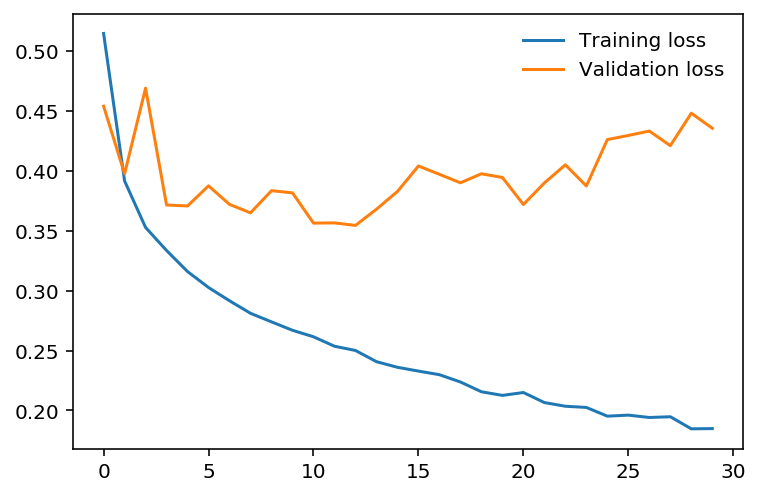

In [10]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [0]:

#overfitting
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [12]:
# turn off gradients
with torch.no_grad():

    # set model to evaluation mode
    model.eval()

    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
model.train()

Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)

In [0]:
#Exercise: Add dropout to your model and train it on Fashion-MNIST again. See if you can get a lower validation loss.
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [14]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.614..  Test Loss: 0.479..  Test Accuracy: 0.831
Epoch: 2/30..  Training Loss: 0.481..  Test Loss: 0.471..  Test Accuracy: 0.832
Epoch: 3/30..  Training Loss: 0.452..  Test Loss: 0.422..  Test Accuracy: 0.849
Epoch: 4/30..  Training Loss: 0.430..  Test Loss: 0.389..  Test Accuracy: 0.857
Epoch: 5/30..  Training Loss: 0.415..  Test Loss: 0.413..  Test Accuracy: 0.851
Epoch: 6/30..  Training Loss: 0.407..  Test Loss: 0.406..  Test Accuracy: 0.859
Epoch: 7/30..  Training Loss: 0.407..  Test Loss: 0.389..  Test Accuracy: 0.862
Epoch: 8/30..  Training Loss: 0.395..  Test Loss: 0.387..  Test Accuracy: 0.862
Epoch: 9/30..  Training Loss: 0.392..  Test Loss: 0.381..  Test Accuracy: 0.860
Epoch: 10/30..  Training Loss: 0.386..  Test Loss: 0.384..  Test Accuracy: 0.863
Epoch: 11/30..  Training Loss: 0.384..  Test Loss: 0.381..  Test Accuracy: 0.866
Epoch: 12/30..  Training Loss: 0.375..  Test Loss: 0.376..  Test Accuracy: 0.869
Epoch: 13/30..  Training Loss: 0.381.

In [0]:

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt


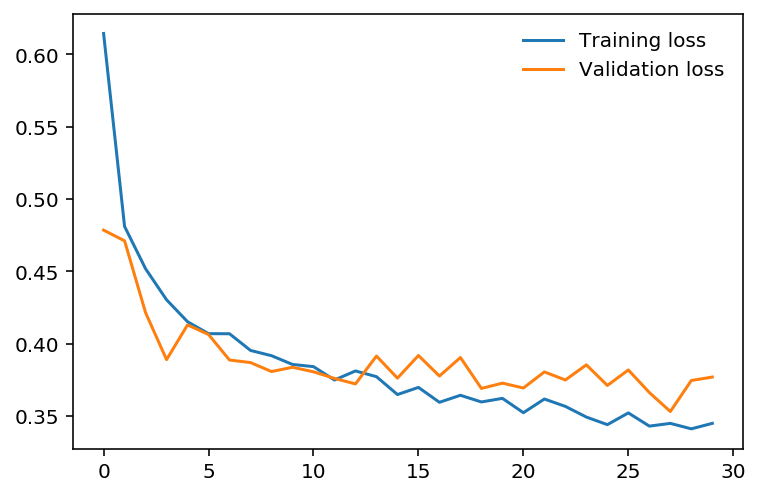

In [16]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [17]:
!wget https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py


--2020-02-18 16:20:48--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2813 (2.7K) [text/plain]
Saving to: ‘helper.py.3’

helper.py.3         100%[===================>]   2.75K  --.-KB/s    in 0s      

2020-02-18 16:20:48 (86.3 MB/s) - ‘helper.py.3’ saved [2813/2813]



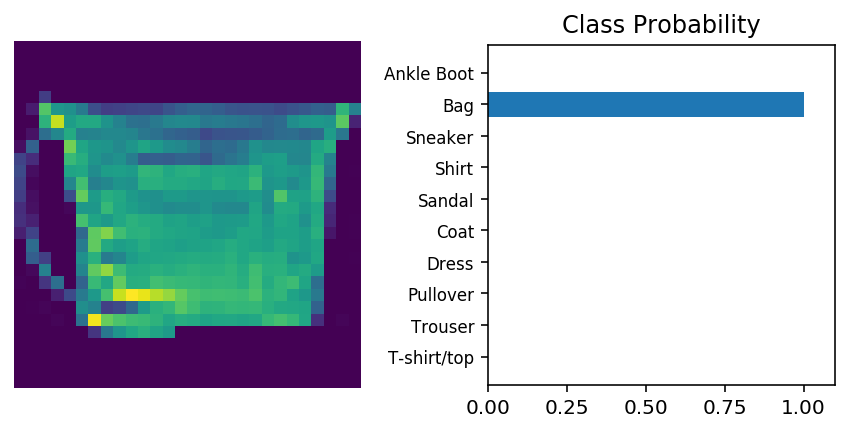

In [18]:
# Import helper module (should be in the repo)
import helper

# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')